In [1]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
sns.set_style("whitegrid")


In [2]:
# Import the our VAE
from VAE_128 import ConvolutionalVariationalAutoencoder,ReparameterizedDiagonalGaussian

latent_features = 26 # Has to be the number that the model was trained with
cvae = ConvolutionalVariationalAutoencoder([1,1,128,128], latent_features)

# Load in the model which has been trained in Google Colab
checkpoint = torch.load('trained_cvae_128.pth', map_location=torch.device('cpu'))

# Apply the weights to the model
cvae.load_state_dict(checkpoint)

# Set the model to evaluation mode (important for dropout/batchnorm layers)
cvae.eval()

ConvolutionalVariationalAutoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=16384, out_features=52, bias=True)
  )
  (conv_decoder): Sequential(
    (0): Linear(in_features=26, out_features=16384, bias=True)
   

In [3]:
# Load the data
data_path = 'data_numpy/density128_sequential.npy'
data = np.load(data_path)

# Prepare list to store means
latent_means = []

# Ensure model is in eval mode and on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvae.to(device)
cvae.eval()

print(f"Processing {data.shape[0]} images...")

# Loop through the data
with torch.no_grad():
    for i in range(data.shape[0]):
        # Get single image
        img = data[i]
        
        # Convert to tensor and add batch and channel dimensions: (1, 1, 128, 128)
        # We assume the data is already normalized or in the correct range for the model
        img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0).to(device)
        
        # Get posterior distribution q(z|x)
        posterior = cvae.posterior(img_tensor)
        
        # Get the mean (mu) of the latent distribution
        mu = posterior.mu.cpu().numpy()
        
        # Append to list (remove batch dimension)
        latent_means.append(mu.squeeze())

# Convert to numpy array
latent_means_array = np.array(latent_means)

print(latent_means_array[0])

Processing 70 images...
[-3.3036277  -2.1766577  -1.8436152  -3.8234894  -1.1268592  -0.5605855
 -1.9723678   5.0533743   1.7656847   0.05217718 -0.22232307  1.2835277
  2.261117   -1.26233     1.8950716   0.51865864 -0.04968629  0.7725146
  1.380914   -2.200593   -0.8560547   1.2157342   1.650964    1.2803668
 -0.05234287  4.8195806 ]
[-3.3036277  -2.1766577  -1.8436152  -3.8234894  -1.1268592  -0.5605855
 -1.9723678   5.0533743   1.7656847   0.05217718 -0.22232307  1.2835277
  2.261117   -1.26233     1.8950716   0.51865864 -0.04968629  0.7725146
  1.380914   -2.200593   -0.8560547   1.2157342   1.650964    1.2803668
 -0.05234287  4.8195806 ]


In [4]:
class LatentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(LatentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        # Note: dropout in LSTM constructor is only applied between layers if num_layers > 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))  
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Decode
        out = self.fc(out)
        return out

# Hyperparameters - SIMPLIFIED MODEL
input_size = 26   
hidden_size = 32  # Reduced from 64 to prevent overfitting
num_layers = 1    # Reduced from 2 to prevent overfitting
output_size = 26  
learning_rate = 0.001
num_epochs = 200
dropout_prob = 0.5 # High dropout for small dataset

# Initialize model
model = LatentRNN(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
# Added weight_decay (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

print(model)

LatentRNN(
  (lstm): LSTM(26, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=26, bias=True)
)


In [5]:
# Prepare the data for the RNN
# We want to predict the next latent vector given a sequence of previous ones

seq_length = 5 # Number of previous time steps to use for prediction
train_split = 0.8

# Create sequences
X = []
y = []
for i in range(len(latent_means_array) - seq_length):
    X.append(latent_means_array[i:i+seq_length])
    y.append(latent_means_array[i+seq_length])

X = np.array(X)
y = np.array(y)

# Convert to tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Split into train and test
split_idx = int(len(X) * train_split)
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]

# Create DataLoaders
batch_size = 8 # Small batch size since we have very few data points (70 total)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Input shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")

Training samples: 52
Test samples: 13
Input shape: torch.Size([52, 5, 26])
Target shape: torch.Size([52, 26])


Epoch [20/200], Train Loss: 5.027437, Test Loss: 12.230181
Epoch [40/200], Train Loss: 4.465020, Test Loss: 12.077971
Epoch [40/200], Train Loss: 4.465020, Test Loss: 12.077971
Epoch [60/200], Train Loss: 3.884482, Test Loss: 11.915573
Epoch [60/200], Train Loss: 3.884482, Test Loss: 11.915573
Epoch [80/200], Train Loss: 3.569509, Test Loss: 11.806693
Epoch [80/200], Train Loss: 3.569509, Test Loss: 11.806693
Epoch [100/200], Train Loss: 3.412651, Test Loss: 11.711267
Epoch [100/200], Train Loss: 3.412651, Test Loss: 11.711267
Epoch [120/200], Train Loss: 3.583448, Test Loss: 11.570254
Epoch [120/200], Train Loss: 3.583448, Test Loss: 11.570254
Epoch [140/200], Train Loss: 3.236643, Test Loss: 11.504426
Epoch [140/200], Train Loss: 3.236643, Test Loss: 11.504426
Epoch [160/200], Train Loss: 3.157401, Test Loss: 11.476181
Epoch [160/200], Train Loss: 3.157401, Test Loss: 11.476181
Epoch [180/200], Train Loss: 3.012208, Test Loss: 11.447155
Epoch [180/200], Train Loss: 3.012208, Test Los

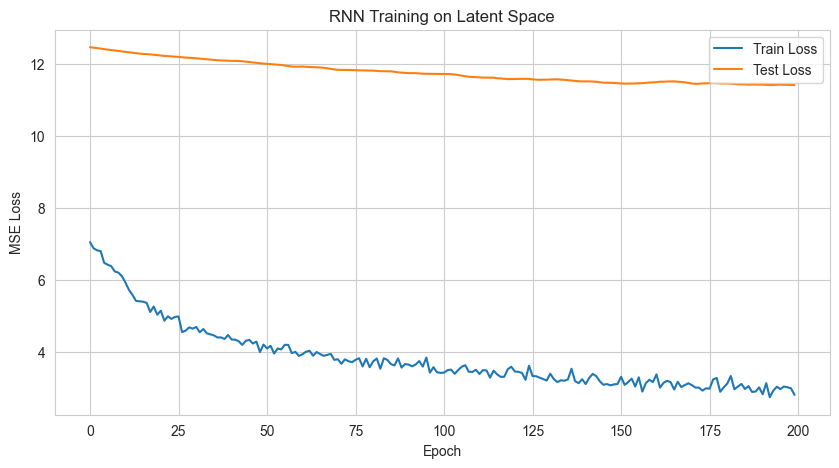

In [6]:
# Training Loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_test_loss += loss.item()
            
    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('RNN Training on Latent Space')
plt.show()